<a href="https://colab.research.google.com/github/Ulises-Diaz/ViT-projects/blob/main/ViT_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 0. Setting for ViT transformer

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 4393 (delta 1458), reused 1410 (delta 1403), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Get data



In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors

In [7]:
# Create image size (from table 3 in the ViT paper)

IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])
print(f'Manually Created transforms: {manual_transforms}')


Manually Created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set batch Size

BATCH_SIZE = 32 #Change for ViT paper

# Create data loaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms, # use manually created transforms
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ac8b5991870>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from scratch
image, label = image_batch [0], label_batch [0]

image.shape , label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

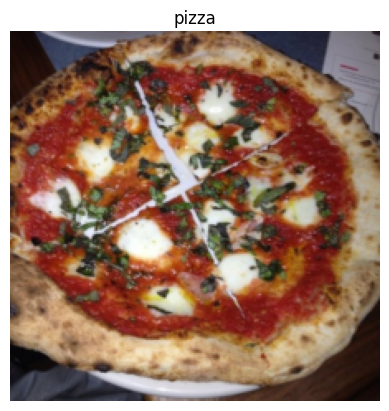

In [10]:
plt.imshow(image.permute(1 , 2 , 0)) # rearrange image dimensions
plt.title(class_names[label])
plt.axis(False)

#### Replicating ViT architecture

Need :
* Patch Embedding : Turn image into embedded patches
* Transformer encoder layer (This is of alternating a MSAwith a MLP block)
* Stack multiple transformer encoder layer on top of each other
* MLP head
* Put it all together

#### 1. Make Patchembedding layer

In [11]:
rand_image_tensor = torch.rand(32,3,224, 224) # (batch size, color_channels, height, width)
rand_image_tensor.shape


torch.Size([32, 3, 224, 224])

In [12]:
#  1. Create a class


class PatchEmbedding(nn.Module):
  '''

  Turns a 2D input image into a 1D sequence learnable embedding vector

  Args :
    * in_channels (int): # Color channels for the input image
    * patch_size (int) : Size patches to conveert input image
    * emedding_dim (int) : Size of embedding to turn image into

  '''

  # 2. Initialize the class
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 16, #how many batches we r applying in our image
               embedding_dim : int = 768):
    super().__init__()
    self.patch_size = patch_size

      # 3. Create a layer to turn image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels ,
                             out_channels = embedding_dim ,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding= 0)

    # 4. Create a layer to flatten the patch feature maps into a single dimensions
    self.flatten = nn.Flatten (start_dim = 2, #only flatten the feature map
                               end_dim = 3)


  # 5. Forward pass
  def forward (self, x) :

    #Create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f'Input image must be divisible by patch size, image shape : {image_resolution} , patch size : {self.patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. COnfirm output shape has same order
    return x_flattened.permute(0,2,1)

In [13]:
patch_embedding = PatchEmbedding(patch_size = 16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f' Input shape  : {rand_image_tensor.shape}')
print(f' Output shape : {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)')


 Input shape  : torch.Size([32, 3, 224, 224])
 Output shape : torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


#### 2. Transformer Encoder Layer

Check the Architecture of the Transformer Encoder in the ViT paper.

In [32]:
# All this hyperparameters r the ones of the ViT paper for the ViT basis. Change this according to ur model



transformer_encoder_layer = nn.TransformerEncoderLayer(d_model= 768, # Hidden Size D
                                                       nhead = 12, # Heads
                                                       dim_feedforward=3072, #MLP SIZE
                                                       dropout = 0.1, # Prevents Overfitting by droping out connections between layers. Connections left r better and have more connection to other
                                                       # Dropouts are the '+' symbols in the Architecture
                                                       activation = "gelu", # Non- linear function
                                                       batch_first = True,  #passing images with the dimension layer first
                                                       norm_first = False) # To do prior attention and feedforward operations, otherwise it's done after .
                                                       #Change norm_first to false for optimize process

transformer_encoder_layer

# Transformer Encoder Layer stack 12 of the code above


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
from torchinfo import summary

summary(model = transformer_encoder_layer,
        input_size = patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            --
├─MultiheadAttention: 1-1                [32, 196, 768]            2,362,368
├─Dropout: 1-2                           [32, 196, 768]            --
├─LayerNorm: 1-3                         [32, 196, 768]            1,536
├─Linear: 1-4                            [32, 196, 3072]           2,362,368
├─Dropout: 1-5                           [32, 196, 3072]           --
├─Linear: 1-6                            [32, 196, 768]            2,360,064
├─Dropout: 1-7                           [32, 196, 768]            --
├─LayerNorm: 1-8                         [32, 196, 768]            1,536
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 151.22
Input size (MB): 19.27
Forward/backward pass size (MB): 269.75
Params size (MB): 18.90
Estimated Total Size (MB): 307.92

 ### 3 . Stack Trnasformer Encoder Layers on top of each other to make the full Transformer Encoder

 ViT paper uses 12 Transformer Encoder Layer

In [47]:


transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

transformer_encoder


summary(model=transformer_encoder,
       input_size=patch_embedding_output.shape)



Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            --
│    │    └─MultiheadAttention: 3-1      [32, 196, 768]            2,362,368
│    │    └─Dropout: 3-2                 [32, 196, 768]            --
│    │    └─LayerNorm: 3-3               [32, 196, 768]            1,536
│    │    └─Linear: 3-4                  [32, 196, 3072]           2,362,368
│    │    └─Dropout: 3-5                 [32, 196, 3072]           --
│    │    └─Linear: 3-6                  [32, 196, 768]            2,360,064
│    │    └─Dropout: 3-7                 [32, 196, 768]            --
│    │    └─LayerNorm: 3-8               [32, 196, 768]            1,536
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            --
│    │    └─MultiheadAttention: 3-9      [32, 196, 768]   

#### 5. Put together and create ViT

In [48]:

class VIT(nn.Module):
  def __init__ (self,
                img_size = 224,  # Resolution Image
                num_channels = 3,
                patch_size = 16,
                embedding_dim = 768, # From table 1
                dropout = 0.1,
                mlp_size = 3072, # From table 1
                num_transformer_layer = 12,  # From table 1
                num_heads = 12,
                num_classes = 1000): # generic # classes
    super().__init__ ()

  # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "image size must be divisible by patch size"

  # 1. Create Patch Embedding

    self.patch_embedding = PatchEmbedding(in_channels = num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

  # 2. Create Class token
    '''

    Note that class token helps the model. In the architecture of ViT, it is the one with '*' symbol

    '''
    self.class_token = nn.Parameter(torch.randn(1,1, embedding_dim),
                                    requires_grad = True)

  # 3. Create positional embedding

    num_patches = (img_size * img_size) // patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

  # 4. Create patch + positional embedding dropout

    self.embedding_dropout = nn.Dropout(p=dropout)


  # 5. Create Transformer Encoder Layer

    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim ,
    #                                                             nhead = 12,
    #                                                             dim_feedforward= 2048,
    #                                                             dropout = 0.1,
    #                                                             activation = "gelu",
    #                                                             batch_first = True,
    #                                                             norm_first = False)

  # 6. Create stack Transformer Encoder Layers (stack single layers)

    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model = embedding_dim ,
                                                                nhead = 12,
                                                                dim_feedforward= 2048,
                                                                dropout = 0.1,
                                                                activation = "gelu",
                                                                batch_first = True,
                                                                norm_first = False),
                                                     num_layers= num_transformer_layer)


  # 7. Create MLP head
    self.mlp_head = nn.Sequential(
      nn.LayerNorm(normalized_shape = embedding_dim),
      nn.Linear(in_features = embedding_dim,
                out_features = num_classes)
  )


  # 8. Forward method to connect all above
  def forward (self, x):

    # Get dimensions from x
    batch_size = x.shape[0]

    # Create patch embeddding
    x = self.patch_embedding(x)
    print(x.shape)

    # Expand the class token across the batch size
    class_token = self.class_token.expand(batch_size , -1, -1) # with -1 we can infere the dimension

    # Preprend the class token to the patch embedding
    '''

    We do it here because we want our class token to change dinamicamente.

    '''

    x = torch.cat((class_token, x), dim=1)
    print(x.shape)


    # Add positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    print(x.shape)

    # Droppout on patch + positional embedding
    x = self.embedding_dropout(x)


    # Pass embedding through Transformer Encoder Stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[: , 0 ])

    return x





In [49]:

demo_img = torch.randn(1,3,224,224)
print(demo_img.shape)


# Create ViT
vit = VIT(num_classes= len(class_names))
vit(demo_img)



torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


tensor([[-0.0098, -0.1779,  0.1267]], grad_fn=<AddmmBackward0>)

In [50]:
summary(model=VIT(num_classes = 1000),
        input_size = demo_img.shape)

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Layer (type:depth-idx)                        Output Shape              Param #
VIT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [51]:
embedding_dim =768

class_token = nn.Parameter(torch.randn(1,1, embedding_dim),
                                requires_grad = True)


class_token.requires_grad

True

In [52]:
img_size = 224
patch_size = 16
num_patches = (img_size * img_size) // patch_size**2
pos_embedding =nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))
pos_embedding.shape #keep track where patches appear in a sequence to relate to each other. Spatial information

torch.Size([1, 197, 768])

## Turn the custom ViT into a Python Script




In [53]:

 %%writefile vit.py

 import torch
 from torch import nn


#  1. Create a class


class PatchEmbedding(nn.Module):
  '''

  Turns a 2D input image into a 1D sequence learnable embedding vector

  Args :
    * in_channels (int): # Color channels for the input image
    * patch_size (int) : Size patches to conveert input image
    * emedding_dim (int) : Size of embedding to turn image into

  '''

  # 2. Initialize the class
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 16, #how many batches we r applying in our image
               embedding_dim : int = 768):
    super().__init__()
    self.patch_size = patch_size

      # 3. Create a layer to turn image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels ,
                             out_channels = embedding_dim ,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding= 0)

    # 4. Create a layer to flatten the patch feature maps into a single dimensions
    self.flatten = nn.Flatten (start_dim = 2, #only flatten the feature map
                               end_dim = 3)


  # 5. Forward pass
  def forward (self, x) :

    #Create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f'Input image must be divisible by patch size, image shape : {image_resolution} , patch size : {self.patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. COnfirm output shape has same order
    return x_flattened.permute(0,2,1)


class VIT(nn.Module):
  def __init__ (self,
                img_size = 224,  # Resolution Image
                num_channels = 3,
                patch_size = 16,
                embedding_dim = 768, # From table 1
                dropout = 0.1,
                mlp_size = 3072, # From table 1
                num_transformer_layer = 12,  # From table 1
                num_heads = 12,
                num_classes = 1000): # generic # classes
    super().__init__ ()

  # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "image size must be divisible by patch size"

  # 1. Create Patch Embedding

    self.patch_embedding = PatchEmbedding(in_channels = num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

  # 2. Create Class token
    '''

    Note that class token helps the model. In the architecture of ViT, it is the one with '*' symbol

    '''
    self.class_token = nn.Parameter(torch.randn(1,1, embedding_dim),
                                    requires_grad = True)

  # 3. Create positional embedding

    num_patches = (img_size * img_size) // patch_size**2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

  # 4. Create patch + positional embedding dropout

    self.embedding_dropout = nn.Dropout(p=dropout)


  # 5. Create Transformer Encoder Layer

    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim ,
    #                                                             nhead = 12,
    #                                                             dim_feedforward= 2048,
    #                                                             dropout = 0.1,
    #                                                             activation = "gelu",
    #                                                             batch_first = True,
    #                                                             norm_first = False)

  # 6. Create stack Transformer Encoder Layers (stack single layers)

    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model = embedding_dim ,
                                                                nhead = 12,
                                                                dim_feedforward= 2048,
                                                                dropout = 0.1,
                                                                activation = "gelu",
                                                                batch_first = True,
                                                                norm_first = True),
                                                     num_layers= num_transformer_layer)


  # 7. Create MLP head
    self.mlp_head = nn.Sequential(
      nn.LayerNorm(normalized_shape = embedding_dim),
      nn.Linear(in_features = embedding_dim,
                out_features = num_classes)
  )


  # 8. Forward method to connect all above
  def forward (self, x):

    # Get dimensions from x
    batch_size = x.shape[0]

    # Create patch embeddding
    x = self.patch_embedding(x)
    print(x.shape)

    # Expand the class token across the batch size
    class_token = self.class_token.expand(batch_size , -1, -1) # with -1 we can infere the dimension

    # Preprend the class token to the patch embedding
    '''

    We do it here because we want our class token to change dinamicamente.

    '''

    x = torch.cat((class_token, x), dim=1)
    print(x.shape)


    # Add positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    print(x.shape)

    # Droppout on patch + positional embedding
    x = self.embedding_dropout(x)


    # Pass embedding through Transformer Encoder Stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[: , 0 ])

    return x





Overwriting vit.py


In [54]:
!python vit.py


In [56]:
from vit import VIT

imported_vit = VIT()
summary(model= imported_vit,
        input_size = (1,3,224,224))


# Note this is not completly fine. The # parameters we should get (see pytorch documentation, doesnt match completely)

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Layer (type:depth-idx)                        Output Shape              Param #
VIT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             5,513,984
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

IN here it ends section 2. Starting section 3

### 3. Train a pretrained ViT feature extractor model

In [57]:
import torchvision

vit_weight =  torchvision.models.ViT_B_16_Weights.DEFAULT #Best available


# Download pretrained Vit weights and model
pretrained_vit = torchvision.models.vit_b_16(weights = vit_weight)
pretrained_vit

# Freeze all layers in pretrained Vit Model
for param in pretrained_vit.parameters () :
  param.requires_grad = False # Do Not update gradients


# Update pretrained ViT head

embedding_dim = 768 # Vit_Base
set_seeds ()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm( normalized_shape=embedding_dim),
    nn.Linear(in_features= embedding_dim,
              out_features= len(class_names))
)

# Summary Pretrained ViT

summary(model = vit,
        input_size= (1,3,224,224),
        col_names = ["input_size" , "output_size" , "num_params" , "trainable"],
        col_width = 20,
        row_settings = ["var_names"])


torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

THIS IS WRONG, IT SHOULD ONLY BE TRUE THE LAST 3 LAYERS THAT ARE TRAINABLE



In [44]:




# Preprocess the data



In [45]:
# Train a pretrained ViT feature extractor